In [48]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X_blob , y_blob = make_blobs(n_samples=1000,n_features=2,centers=4,random_state=42,cluster_std=1.5)

In [49]:
X_blob.shape

(1000, 2)

In [50]:
y_blob.shape

(1000,)

In [51]:
X_train , X_test , y_train , y_test = train_test_split(X_blob,y_blob,test_size=0.2,random_state=42)

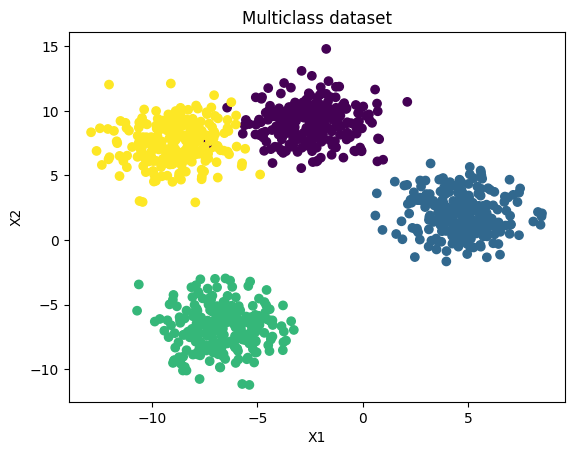

In [52]:
import matplotlib.pyplot as plt
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob)
plt.title("Multiclass dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [53]:
# Device Agnostic code
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [54]:
X_train = torch.from_numpy(X_train).type(torch.float32).to(device)
X_test = torch.from_numpy(X_test).type(torch.float32).to(device)
y_train = torch.from_numpy(y_train).type(torch.LongTensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.LongTensor).to(device)

In [55]:
class MultiClassModel(nn.Module):
  def __init__(self , input_features , output_features , hidden_units = 16):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features,out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units,out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units,out_features = output_features)
    )
  def forward(self , x):
    return self.linear_layer_stack(x)


In [56]:
model_0 = MultiClassModel(input_features = 2,output_features = 4,hidden_units = 16).to(device)

In [57]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),lr=0.15)

In [58]:
y_logits = model_0(X_train)
y_logits

tensor([[-0.4077, -0.0721, -0.3683, -0.1913],
        [ 0.0326, -0.2728, -0.6158, -0.9059],
        [ 0.7658,  0.7030,  0.1517, -0.8068],
        ...,
        [-0.0088, -0.2540, -0.6377, -0.9186],
        [ 0.6065,  0.5403,  0.0946, -0.6536],
        [ 0.3211,  0.1140, -0.1216, -0.6270]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [59]:
y_logits.shape

torch.Size([800, 4])

In [60]:
def accuracy_fn(y_true , y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [61]:
accuracy_fn(y_train , y_preds)

99.5

In [62]:
epochs = 101

for i in range(epochs):
  y_logits = model_0(X_train)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_train,y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    y_test_preds_logits = model_0(X_test)
    test_loss = loss_fn(y_test_preds_logits,y_test)
    y_test_preds = torch.softmax(y_test_preds_logits,dim=1).argmax(dim=1)
    acc_test = accuracy_fn(y_test_preds,y_test)

    # Print out what's happening
    if i % 10 == 0:
        print(f"Epoch: {i} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {acc_test:.2f}%")


Epoch: 0 | Loss: 1.44599, Acc: 49.75% | Test Loss: 0.70188, Test Acc: 47.00%
Epoch: 10 | Loss: 0.05511, Acc: 99.00% | Test Loss: 0.03959, Test Acc: 99.00%
Epoch: 20 | Loss: 0.04766, Acc: 99.25% | Test Loss: 0.00947, Test Acc: 99.50%
Epoch: 30 | Loss: 0.02261, Acc: 99.50% | Test Loss: 0.00806, Test Acc: 99.50%
Epoch: 40 | Loss: 0.18001, Acc: 96.50% | Test Loss: 0.11390, Test Acc: 97.50%
Epoch: 50 | Loss: 0.06234, Acc: 98.12% | Test Loss: 0.04202, Test Acc: 98.50%
Epoch: 60 | Loss: 0.02757, Acc: 99.38% | Test Loss: 0.02040, Test Acc: 99.50%
Epoch: 70 | Loss: 0.02091, Acc: 99.12% | Test Loss: 0.00506, Test Acc: 100.00%
Epoch: 80 | Loss: 0.01859, Acc: 99.25% | Test Loss: 0.00540, Test Acc: 100.00%
Epoch: 90 | Loss: 0.01684, Acc: 99.50% | Test Loss: 0.00652, Test Acc: 100.00%
Epoch: 100 | Loss: 0.01571, Acc: 99.50% | Test Loss: 0.00335, Test Acc: 100.00%


In [63]:
from pathlib import Path
import requests
request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

In [64]:
with open("helper_functions.py","wb") as f:
  f.write(request.content)

In [67]:
from helper_functions import plot_predictions, plot_decision_boundary

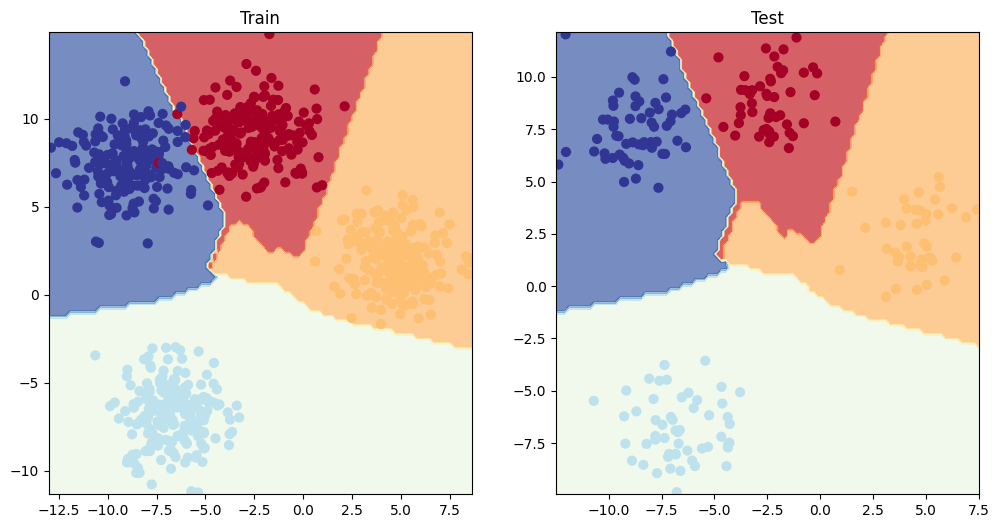

In [68]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)
